Load necessary libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.feature_selection import RFE
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.utils import shuffle
import pandas as pd
import numpy as np

First, load the full subset of QM9 available through our GitHub and compute features using Mordred. You will need to convert all data to a float (see DataFrame.astype) and drop missing values, but do not use any other dimensionality reduction. Once complete, make a test set of 2000 molecules

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True)  # Do not need the full set to make a point.
print(f'Loaded {len(data)} molecules')

Loaded 25000 molecules


In [3]:
data['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles)
calc = Calculator(descriptors, ignore_3D=True)
desc = calc.pandas(data['mol'])

100%|██████████| 25000/25000 [08:30<00:00, 48.98it/s] 


In [4]:
print(f'Computed {len(desc.columns)} descriptors for {len(desc)} molecules')

Computed 1613 descriptors for 25000 molecules


Convert all the data to float

In [5]:
for column in desc.columns:
    desc[column] = pd.to_numeric(desc[column], errors='coerce')

In [6]:
missing_values = desc.isnull().any()
print(f'Found {missing_values.sum()} columns with missing values')

Found 546 columns with missing values


In [7]:
desc = desc.loc[:, ~missing_values]  # Gets only rows that do not (~ means not) have missing values
print(f'New shape: {desc.shape}')

New shape: (25000, 1067)


make a test set of 2000 molecules

In [8]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, test_size=0.08)

In [9]:
train_data_sets = []
train_desc_sets = []
train_set_sizes = [10, 100, 1000, 10000]
for t in train_set_sizes:
    train_data_, train_desc_ = shuffle(train_data, train_desc, n_samples=t)
    train_data_sets.append(train_data_)
    train_desc_sets.append(train_desc_)

# Chemical Descriptors
## #1 Question

### Train a LassoCVLinks model using the features with and without reducing the dimensionality to 8 features using PCA. Then, train a RandomForest modelLinks to an external site. using the default settings.

Train a LassoCV model using the features ***with*** reducing the dimensionality to 8 features using PCA

In [10]:
model_with_pca = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('lasso', LassoCV())
])

In [11]:
results = []
test_data = test_data.copy()  # Avoids some pandas issues
for index, t in enumerate(train_set_sizes):
    test_data['8-ncomp-model-'+str(t)] = model_with_pca.fit(train_desc_sets[index], train_data_sets[index]['bandgap']).predict(test_desc)
    results.append({
                'train_size': t,
                'mae': mean_absolute_error(test_data['bandgap'], test_data['8-ncomp-model-'+str(t)])
            })
results = pd.DataFrame(results)

Train a LassoCV model using the features ***without*** reducing the dimensionality to 8 features using PCA

In [12]:
model_without_pca = Pipeline([
    ('scale', StandardScaler()),
    # ('rfe', RF)
    ('lasso', LassoCV(max_iter=10000)) # When max_iter is set to default (1000), the model would not converge
])

In [13]:
results_without = []
test_data = test_data.copy()  # Avoids some pandas issues
for index, t in enumerate(train_set_sizes):
    test_data['without-ncomp-model-'+str(t)] = model_without_pca.fit(train_desc_sets[index], train_data_sets[index]['bandgap']).predict(test_desc)
    results_without.append({
                'train_size': t,
                'mae': mean_absolute_error(test_data['bandgap'], test_data['without-ncomp-model-'+str(t)])
            })
results_without = pd.DataFrame(results_without)

Train a RandomForestRegression using default setting

In [14]:
model_RFR = Pipeline([
    ('scale', StandardScaler()),
    ('randomforest', RandomForestRegressor())
])

In [15]:
results_RFR = []
test_data = test_data.copy()  # Avoids some pandas issues
for index, t in enumerate(train_set_sizes):
    test_data['RFR-default-model-'+str(t)] = model_RFR.fit(train_desc_sets[index], train_data_sets[index]['bandgap']).predict(test_desc)
    results_RFR.append({
                'train_size': t,
                'mae': mean_absolute_error(test_data['bandgap'], test_data['RFR-default-model-'+str(t)])
            })
results_RFR = pd.DataFrame(results_RFR)

Plot the change in mean absolute error (MAE) with respect to training set sizes: 10, 100, 1000, 10000. 

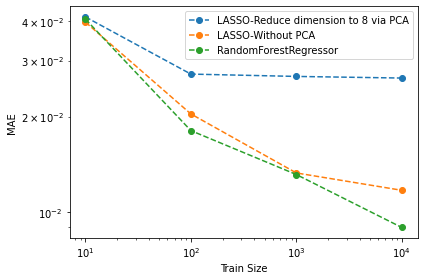

In [16]:
fig, ax = plt.subplots()
ax.loglog(train_set_sizes, results['mae'], '--o', label="LASSO-Reduce dimension to 8 via PCA")
ax.loglog(train_set_sizes, results_without['mae'], '--o', label="LASSO-Without PCA")
ax.loglog(train_set_sizes, results_RFR['mae'], '--o', label="RandomForestRegressor")
ax.legend()

ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
fig.tight_layout()

The graph above showed that for LASSO model, when the features' dimention is reduced to 8, MAE would not decrease at large training size, while two other model (LASSO without PCA and RandomForestRegression) would continue to increase accuracy. There are two reasons that lead to the result. 

- Let's focus on the behaviors of two LASSO methods first. When training features are set to limited number (e.g. 8), model can be easily trained and even become overfitting with small amount of training data, while models with large sets of features don't. In that case, ***LASSO-Without PCA*** would continue converging, while ***LASSO-Reduce dimension to 8 via PCA*** stop converging at large training size.
- What's more, the nature of algorithm really matters. ***RandomForestRegression*** is based on RandomTree Algorithm, which is actually a decision tree for one feature. ***RandomForestRegression*** generates tens of thousands of RandomTrees to deal with lots of features independently and parellely. In that case, ***RandomForestRegression*** is considered as one of the best ML algorithms that can deal with high-demensional data or many-feature data. However, ***LASSO*** is just a Linear Regression algorithm, which means that dealing with high-dimentional data is not ***LASSO***'s strength. That's the reason why ***RandomForestRegression*** performs better that ***LASSO*** at large training size.

## #2 Question
### Train the LASSO without PCA (using coefficients) and RandomForest models (using the assigned feature scores) on 10^4 data points. Rank the top features for random forest and LASSO

In [17]:
model_LassoCV = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV(max_iter=10000)) # When max_iter is set to default (1000), the model would not converge
])

In [18]:
lasso = model_LassoCV.fit(train_desc_sets[-1], train_data_sets[-1]['bandgap'])

In [19]:
largest_corr_set = np.argsort(lasso['lasso'].coef_)[-10:]
print("top features for LASSO: ", desc.keys()[largest_corr_set[::-1]])

top features for LASSO:  Index(['ATSC2se', 'SsOH', 'GATS1dv', 'SMR_VSA7', 'NssO', 'ATSC1Z', 'GATS2dv',
       'NdsCH', 'SsNH2', 'GATS1c'],
      dtype='object')


In [20]:
model_RFR = Pipeline([
    ('scale', StandardScaler()),
    ('RFR', RandomForestRegressor())
])

In [21]:
rfr = model_RFR.fit(train_desc_sets[-1], train_data_sets[-1]['bandgap'])

In [22]:
largest_corr_set_rfr = np.argsort(rfr['RFR'].feature_importances_)[-10:]
print("top features for RandomForestRegression: ", desc.keys()[largest_corr_set_rfr[::-1]])

top features for RandomForestRegression:  Index(['nBondsKD', 'GATS1c', 'FCSP3', 'C2SP2', 'AETA_beta', 'nBondsD',
       'VSA_EState2', 'piPC4', 'ETA_beta', 'BCUTdv-1h'],
      dtype='object')


### 2.1. Compare the top 10 features with random forest and Lasso (Hint: Python set logicLinks to an external site.). Are any the same? Why is this expected?

In [23]:
set_lasso, set_rfr = set(desc.keys()[largest_corr_set[::-1]]), set(desc.keys()[largest_corr_set_rfr[::-1]])
both = set_lasso.intersection(set_rfr)
print(f'Two methods have {len(both)} overlap most important features')

Two methods have 1 overlap most important features


None of them is the same. This is not what I expected. But this is reasonable becuase LASSO and RandomForestRegression have different logic or strategies to define important features. LASSO determins a linear combination of features and computes the coefficients of features, while RandomForestRegression computes how much the features contribute to the decrease of loss function.

### 2.2. Assess the correlation between. What does this imply about how to interpret the most important features?

In [24]:
feat_score_lasso = [np.corrcoef(data['bandgap'], desc[f])[0][1] for f in set_lasso]

Text(0.5, 0, 'Feature ID')

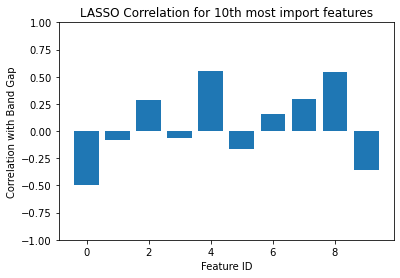

In [25]:
fig, ax = plt.subplots()

ax.bar(range(len(feat_score_lasso)), feat_score_lasso)

ax.set_ylim(-1, 1)
ax.set_title('LASSO Correlation for 10th most import features')
ax.set_ylabel(f'Correlation with Band Gap')
ax.set_xlabel('Feature ID')

In [26]:
feat_score_rfr = [np.corrcoef(data['bandgap'], desc[f])[0][1] for f in set_rfr]

Text(0.5, 0, 'Feature ID')

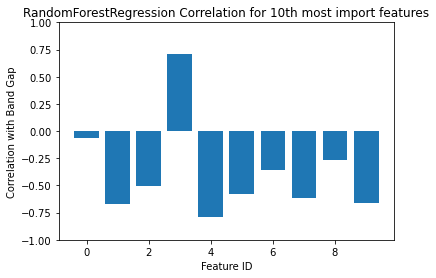

In [27]:
fig, ax = plt.subplots()

ax.bar(range(len(feat_score_rfr)), feat_score_rfr)

ax.set_ylim(-1, 1)
ax.set_title('RandomForestRegression Correlation for 10th most import features')
ax.set_ylabel(f'Correlation with Band Gap')
ax.set_xlabel('Feature ID')

The results imply that correlations between features and target attributes are important but not directly determine features' importances. The interpretation of important features needs to obey the logic of the algorithm as well as nature.

### 2.3. Run the test twice for once of the models. Do the results change between runs?

Run LASSO again, compare importent features:

In [28]:
model_LassoCV_2 = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV(max_iter=10000)) # When max_iter is set to default (1000), the model would not converge
])

In [29]:
train_data_shuffle, train_desc_shuffle = shuffle(train_data, train_desc, n_samples=10000)
lasso2 = model_LassoCV_2.fit(train_desc_shuffle, train_data_shuffle['bandgap'])

In [30]:
largest_corr_set_2 = np.argsort(lasso2['lasso'].coef_)[-10:]
print("top features for LASSO: ", desc.keys()[largest_corr_set_2[::-1]])

top features for LASSO:  Index(['ATSC2se', 'SssO', 'GATS1dv', 'SsOH', 'SMR_VSA7', 'GATS2dv', 'GATS1c',
       'SlogP_VSA6', 'NdsCH', 'piPC4'],
      dtype='object')


In [31]:
set_lasso2 = set(desc.keys()[largest_corr_set_2[::-1]])
both = set_lasso.intersection(set_lasso2)
print(f'Repeat test on LASSO have {len(both)} overlap most important features')

Repeat test on LASSO have 7 overlap most important features


The result slightly change!

### Describe what these results mean for interpreting the features of machine learning models.

Choosing correct features means a lot to the success of model training. However, there are different strategies of choosing the most important features based on the logic of algorithm and nature. What's more, correlations between features and target attributes help us to better screen features, but it's not decisive.

## #3 Question
### Discuss the relative advantages of RandomForest versus Linear Regression versus Linear Regression with PCA.

- RandomForestRegression, which based on RandomTree, is considered as one of the best ML algorithm to deal with high-dimension data. Each RandomTree can run parellely and independently on each feature.
- LinearRegression is faster than RandomForestRegression if both are run serially. It is also able to capture information from high-dimension data.
- LinearRegression with PCA is the fastest among all three algorithm. It can easily reach convergence since the number of features are dramatiacally reduced. However, if can easily overfit on large amount of high-dimension data.

# Molecular Fingerprints
## #1 Question
### Create a training set of 1000 entries. Train a k-Nearest Neighbors (kNN) regressor model using a Jaccard distance metric based on 128-length Morgan fingerprint with a radius of 3. Plot how the performance on the model on a test set of 2000 entries changes as you increase the number of neighbors used in kNN from 1 to 2<sup>7</sup>. Explain why the MAE improves when increasing from 1 and then worsens as you increase past 2<sup>8</sup>.

In [32]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    molecule = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=np.bool)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr


class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    """Class that converts SMILES strings to fingerprint vectors"""
    
    def __init__(self, length: int = 256, radius: int = 4):
        self.length = length
        self.radius = radius
    
    def fit(self, X, y=None):
        return self  # Do need to do anything
    
    def transform(self, X, y=None):
        """Compute the fingerprints
        
        Args:
            X: List of SMILES strings
        Returns:
            Array of fingerprints
        """
        
        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in X]
        return np.vstack(fing)


In [33]:
model = Pipeline([
    ('fingerprint', MorganFingerprintTransformer(128, 3)),
    ('knn', KNeighborsRegressor(n_neighbors=2, metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
])

In [34]:
train_data, test_data = train_test_split(data, test_size=0.08)
train_subset = shuffle(train_data, n_samples=1000)

In [35]:
results = []
number_neighbor_sets = [2 ** n for n in range(8)]
for number_neighbor in number_neighbor_sets:
    model.set_params(knn__n_neighbors=number_neighbor)
    model.fit(train_subset['smiles_0'], train_subset['bandgap'])
    y_pred = model.predict(test_data['smiles_0'])
    results.append({
                'number_neighbor': number_neighbor,
                'mae': mean_absolute_error(test_data['bandgap'], y_pred)
            })
results = pd.DataFrame(results)  # Converts to a dataframe

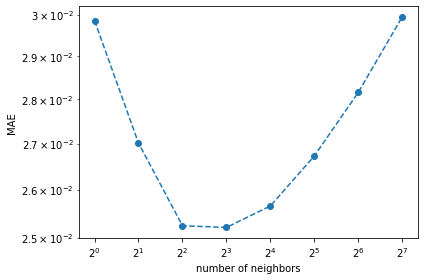

In [36]:
fig, ax = plt.subplots()

ax.loglog(results['number_neighbor'], results['mae'], '--o')
ax.set_xlabel('number of neighbors')
ax.set_xscale('log', base=2)
ax.set_ylabel('MAE')
fig.tight_layout()

The reason why MAE improves when increasing from 1 and then worsens as you increase past 2^4^ is because of the logic of KNN algorith. When # of neighbors increases, the references used to predict properties increase, which helps model to better give out a general prediction. However, when # of neighbors continue to increase, it is almost inevitable that large amount of reference data bring nonlocal terms to the model, which would, however, lead to poor performance in predictions if the nonlocal term contributes a lot to the model. All in all, ***KNN is a semilocal ML model***, which means that the choice of # of neighors means a lot to the model.

## #2 Quesion
### Add a step in the model Pipeline from Step 1 that uses Recursive Feature with a Random Forest model to reduce the number of features to 32 in 4 steps. Compare the MAE versus number of neighbors to kNN without feature selection.

In [37]:
model_rfe = Pipeline([
    ('fingerprint', MorganFingerprintTransformer(128, 3)),
    ('rfe', RFE(RandomForestRegressor(), n_features_to_select=32, step=4)),
    ('knn', KNeighborsRegressor(n_neighbors=2, metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
])

In [38]:
results_rfe = []
for number_neighbor in number_neighbor_sets:
    model_rfe.set_params(knn__n_neighbors=number_neighbor)
    model_rfe.fit(train_subset['smiles_0'], train_subset['bandgap'])
    y_pred_rfe = model_rfe.predict(test_data['smiles_0'])
    results_rfe.append({
                'number_neighbor': number_neighbor,
                'mae': mean_absolute_error(test_data['bandgap'], y_pred_rfe)
            })
results_rfe = pd.DataFrame(results_rfe)  # Converts to a dataframe

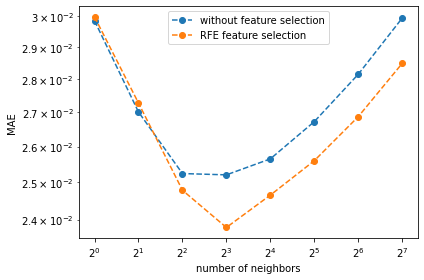

In [39]:
fig, ax = plt.subplots()

ax.loglog(results['number_neighbor'], results['mae'], '--o', label='without feature selection')
ax.loglog(results_rfe['number_neighbor'], results_rfe['mae'], '--o', label='RFE feature selection')
ax.legend()
ax.set_xlabel('number of neighbors')
ax.set_xscale('log', base=2)
ax.set_ylabel('MAE')
fig.tight_layout()

The result above showed that: feature selection does increase the model's accuracy as well as decrease the impact of 'nonlocal' term, so that the model's performance doesn't dramatically reduce when the # of neighbors is bigger than 2<sup>4</sup>.

## #3 Question
### Why would the model with the feature selection perform better? In general terms, explain the disadvantage of using a general-purpose distnace metrics such as fingerprints and how must one must account for that.

Feature Selection process helps to dramatically reduce the dimension of data, which further benefits those models that dependents on the distance between predicted data and reference data (e.g. KNN).

The biggest disadvantage of using distance metrics is that the choice of radius have a big impact on the classification or regression. In that case, one needs to firstly do a test and run over all possible as well as reasonable configurations (e.g. # of neighbor or radius), and finally determines the parameter (hyper-parameter) based on the initial test.